# Initialise main directory


In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
main_dir = '/content/gdrive/My Drive/UpworkNotebooks/Opera Files/'

!ls '{main_dir}'/.

Mounted at /content/gdrive
All_Data  Csv_Files	 Helper_Notebooks  Models
Audios	  Documentation  Main_Notebooks


# Install and import libraries

In [2]:
!pip install -q librosa
!pip install -q pysoundfile
!pip install -q -U keras-tuner

     |████████████████████████████████| 98 kB 3.6 MB/s 


In [3]:
import numpy as np
import pandas as pd

import tensorflow as tf

import keras_tuner as kt
from ast import literal_eval
from joblib import dump, load

import os
import sys
import time

%matplotlib inline

import urllib.request as urllib2 # For python3
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

import librosa
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LogNorm
from PIL import Image

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow import keras
from sklearn.model_selection import train_test_split

# Obtain features and labels


In [ ]:

label_target = {('baritone_bassbaritones', 0), ('baritone_dramatic', 1), ('baritone_lyric', 2), 
                ('tenor_spinto', 8), ('bass_dramatic', 4), ('bass_cantante', 3), ('tenor_leggero', 6), 
                ('tenor_lyric', 7), ('tenor_dramatic', 5)}
labels = [item[0] for item in label_target]
print(label_target)
print(labels)

{('baritone_dramatic', 1), ('bass_cantante', 3), ('tenor_spinto', 8), ('baritone_lyric', 2), ('tenor_dramatic', 5), ('tenor_lyric', 7), ('bass_dramatic', 4), ('tenor_leggero', 6), ('baritone_bassbaritones', 0)}
['baritone_dramatic', 'bass_cantante', 'tenor_spinto', 'baritone_lyric', 'tenor_dramatic', 'tenor_lyric', 'bass_dramatic', 'tenor_leggero', 'baritone_bassbaritones']


In [ ]:
def targets_to_labels(list_to_convert):
  labels=[]
  for item in list_to_convert:
    for label, target in label_target:
      if item == target:
        labels.append(label)
  return labels

#function for removing problematic classes
def remove_problematic(to_remove, processed_data):
  for subregister in to_remove:
    for label, target in label_target:
      if subregister==label:
        processed_data = processed_data[processed_data['class_label'] != target]
  return processed_data

In [ ]:
#read from mfccs data
processed_data = pd.read_csv(main_dir + "Csv_Files/males_mfccs.csv")
processed_data = processed_data.sample(frac=1)

to_evaluate = ['tenor_lyric', 'bass_dramatic', 'baritone_dramatic', 'tenor_dramatic']
to_remove = [item for item in labels if item not in to_evaluate]

processed_data = remove_problematic(to_remove, processed_data)
features = [literal_eval(processed_data['mfccs'].tolist()[i]) for i in range(len(processed_data))]
targets = processed_data["class_label"].tolist()
num_labels = len(set(targets))
print('Selected targets: ', set(targets))
print('Number of classes: ', num_labels )
print('To evaluate: ', to_evaluate)
print('Not considered: ', to_remove)

Selected targets:  {1, 4, 5, 7}
Number of classes:  4
To evaluate:  ['tenor_lyric', 'bass_dramatic', 'baritone_dramatic', 'tenor_dramatic']
Not considered:  ['bass_cantante', 'tenor_spinto', 'baritone_lyric', 'tenor_leggero', 'baritone_bassbaritones']


# Creating PCA components


Components 	 Fraction of explained variance
	 1 	 0.5109344920420109
	 2 	 0.6565559715352112
	 3 	 0.718224014808253
	 4 	 0.768349593928757
	 5 	 0.809088841918365
	 10 	 0.9113414818177122
	 20 	 0.9736612261211209
	 25 	 0.9840226989852411
	 28 	 0.9880432658920889
	 30 	 0.9899750016705166
	 32 	 0.9916678409471362
	 40 	 0.9959541285463233
	 50 	 0.9981930474260887




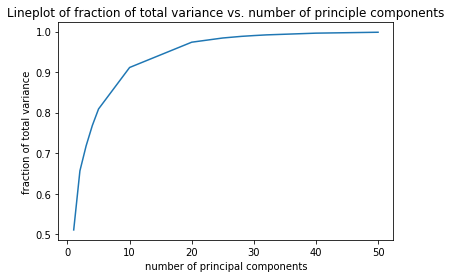

In [ ]:
def get_pca_components(data):
  k = [1, 2, 3, 4, 5, 10, 20, 25, 28, 30, 32, 40, 50]
  explained_variances = []
  print('Components \t Fraction of explained variance')
  for components in k:
    pca = PCA(n_components = components)
    data_pc = pca.fit_transform(data)
    fraction_of_variance = sum(pca.explained_variance_ratio_)
    print('\t',components,'\t',fraction_of_variance)
    explained_variances.append(fraction_of_variance)
  print('\n')
  plt.plot(k, explained_variances)
  plt.xlabel("number of principal components")
  plt.ylabel("fraction of total variance")
  plt.title("Lineplot of fraction of total variance vs. number of principle components")
  plt.show()
  pass

get_pca_components(data = features)

# Train_Test_Split

In [ ]:
components = 32
pca = PCA(n_components = components)
data_pca = pca.fit_transform(features)
dump(pca, main_dir + 'Models/Development/Males_A/PCA/Males_A_pca.joblib') 
print( data_pca[2])
print(data_pca.shape)


[-16.20351128 -54.53967975 -23.17856537  -4.83077942  19.46748536
 -16.95530848 -30.89643358 -18.38295651  10.269057   -14.31020227
  11.26974254   3.07867824  -9.85211213  -3.78238483   0.99668524
  -8.10236204  10.24832086   0.26978139   6.44367959  -0.32094123
  -1.69295083   0.78818039  -1.50969321  -2.59656252   2.65820155
  -2.53378012  -2.28586238  -1.54553092  -5.16756694   0.14644304
  -3.02034969   0.12973005]
(1764, 32)


In [ ]:
standard_scaler = StandardScaler()
X = standard_scaler.fit_transform(data_pca)
dump(standard_scaler, main_dir + 'Models/Development/Males_A/Scaler/Males_A_scaler.joblib')
X = np.array(X)
y = np.array(targets)
y_encoded = LabelEncoder().fit_transform(y)
y_categorical = to_categorical(y_encoded)

mapping = list(set([item for item in zip(y_encoded, targets)]))
label_mapping = {}
for item in mapping:
  label_mapping[int(item[0])] = item[1]

dump(label_mapping, main_dir +  'Models/Development/Males_A/Reports/Males_A_label_mapping.joblib')

x_train, x_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.14)
x_train, x_dev, y_train, y_dev = train_test_split(x_train, y_train, test_size = 0.15)

print('x_train: ',len(x_train))
print('y_train: ', len(y_train))
print('x_test: ',len(x_test))
print('y_test: ',len(y_test))
print('x_dev: ',len(x_dev))
print('y_dev: ',len(y_dev))

datasets = [x_train, y_train, x_test, y_test, x_dev, y_dev]
dataset_names = ['x_train', 'y_train', 'x_test', 'y_test', 'x_dev', 'y_dev']
for dataset, dataset_name in zip(datasets, dataset_names):
  df = pd.DataFrame(dataset)
  folder = dataset_name.split('_')[1].capitalize()
  df.to_csv(main_dir + 'Models/Development/Males_A/Data/{0}/Males_A_{1}.csv'.format(folder, dataset_name), index=False)


x_train:  1289
y_train:  1289
x_test:  247
y_test:  247
x_dev:  228
y_dev:  228


# Keras Tuner

In [ ]:
def model_builder(hp):
  lower = 8
  upper = 196
  step = 4

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Input(shape=(components), dtype=tf.float32,
                          name='input_embedding'))
  hp_units_1 = hp.Int('units_1', min_value=lower, max_value=upper, step=step)
  hp_reg_1 = hp.Float('regs_1', min_value=0.001, max_value=0.1, step=0.001)
  hp_dropout_1 = hp.Float('dropout_1', min_value=0.1, max_value=0.8, step=0.001)
  model.add(keras.layers.Dense(units=hp_units_1, activation='relu', 
                               kernel_regularizer = regularizers.l2(hp_reg_1), name='dense_1'))
  model.add(keras.layers.Dropout(hp_dropout_1))

  # kernel_regularizer=regularizers.l2(hp_reg_1)
  # regularizers.l2(hp_reg_3),
  # Tune the number of units in the Second Dense layer
  hp_units_2 = hp.Int('units_2', min_value=lower, max_value=upper, step=step)
  hp_reg_2 = hp.Float('regs_2', min_value=0.001, max_value=0.1, step=0.001)
  model.add(keras.layers.Dense(units=hp_units_2, activation='relu', 
                               kernel_regularizer = regularizers.l2(hp_reg_2), name='dense_2'))
  
  hp_dropout_2 = hp.Float('dropout_2', min_value=0.1, max_value=0.8, step=0.001)
  model.add(keras.layers.Dropout(hp_dropout_2))

  # kernel_regularizer=regularizers.l1_l2(hp_reg_2)
  # hp_units_3 = hp.Int('units_3', min_value=lower, max_value=upper, step=step)
  # model.add(keras.layers.Dense(units=hp_units_3, activation='relu', name='dense_3'))

  hp_units_4 = hp.Int('units_4', min_value=lower, max_value=upper, step=step)
  # hp_reg_4 = hp.Float('regs_4', min_value=0.001, max_value=0.1, step=0.001)
  # hp_dropout_4 = hp.Float('dropout_4', min_value=0.1, max_value=0.8, step=0.01)
  model.add(keras.layers.Dense(units=hp_units_4, activation='relu', name='dense_4'))
  # model.add(keras.layers.Dropout(hp_dropout_4))

  #Output_Layer
  model.add(keras.layers.Dense(num_labels, activation='softmax', name='output_layer'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4])
  hp_learning_rate = 0.001

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.categorical_crossentropy,
                metrics=['accuracy'])

  return model

In [ ]:

tuner_dir = main_dir + 'Main_Notebooks/Keras_Tuner_Approach/Males_Trials/Keras_Tuner/Males_A'
if os.path.exists(tuner_dir)==False:
  !mkdir "{tuner_dir}"

tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=50,
                     factor=4,
                     directory=tuner_dir,
                     project_name='mk0')
print(tuner_dir)
print(tuner.project_name)

/content/gdrive/My Drive/UpworkNotebooks/Opera Files/Main_Notebooks/Keras_Tuner_Approach/Males_Trials/Keras_Tuner/Males_A
mk0


In [ ]:
!ls "{tuner_dir}"

mk0


In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 8
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 196, 'step': 4, 'sampling': None}
regs_1 (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.001, 'max_value': 0.1, 'step': 0.001, 'sampling': None}
dropout_1 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.8, 'step': 0.001, 'sampling': None}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 196, 'step': 4, 'sampling': None}
regs_2 (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.001, 'max_value': 0.1, 'step': 0.001, 'sampling': None}
dropout_2 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.8, 'step': 0.001, 'sampling': None}
units_4 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 196, 'step': 4, 'sampling': None}
learning_rate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

In [ ]:
tuner.search(x_train, y_train, epochs=180, validation_data=(x_dev, y_dev), callbacks=[stop_early])

Trial 44 Complete [00h 00m 04s]
val_accuracy: 0.6140350699424744

Best val_accuracy So Far: 0.8377193212509155
Total elapsed time: 00h 02m 35s
INFO:tensorflow:Oracle triggered exit


In [ ]:
best_hps = tuner.get_best_hyperparameters()[0]


In [ ]:
print('Layer1 units:', best_hps.get('units_1'))
print('Layer1 l2 regularizer:', best_hps.get('regs_1'))
print('Layer1 dropout:', best_hps.get('dropout_1'))

print('Layer2 units:', best_hps.get('units_2'))
print('Layer2 l2 regularizer:', best_hps.get('regs_2'))
print('Layer2 dropout:', best_hps.get('dropout_2'))

# print('Layer3 units:', best_hps.get('units_3'))
# print('Layer3 l2 regularizer:', best_hps.get('regs_3'))
# print('Layer3 dropout:', best_hps.get('dropout_3'))

print('Layer4 units:', best_hps.get('units_4'))
# print('Layer3 l2 regularizer:', best_hps.get('regs_3'))
# print('Layer4 dropout:', best_hps.get('dropout_4'))


# print('Layer5 units:', best_hps.get('units_5'))
# # print('Layer3 l2 regularizer:', best_hps.get('regs_3'))
# print('Layer5 dropout:', best_hps.get('dropout_5'))

# print('Layer6 units:', best_hps.get('units_6'))
# # print('Layer3 l2 regularizer:', best_hps.get('regs_3'))
# print('Layer6 dropout:', best_hps.get('dropout_6'))

print('Learning Rate:', best_hps.get('learning_rate'))

Layer1 units: 68
Layer1 l2 regularizer: 0.066
Layer1 dropout: 0.12800000000000003
Layer2 units: 48
Layer2 l2 regularizer: 0.044000000000000004
Layer2 dropout: 0.3190000000000002
Layer4 units: 148
Learning Rate: 0.001


In [ ]:
h_model = tuner.hypermodel.build(best_hps)
h_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 68)                2244      
                                                                 
 dropout_2 (Dropout)         (None, 68)                0         
                                                                 
 dense_2 (Dense)             (None, 48)                3312      
                                                                 
 dropout_3 (Dropout)         (None, 48)                0         
                                                                 
 dense_4 (Dense)             (None, 148)               7252      
                                                                 
 output_layer (Dense)        (None, 4)                 596       
                                                                 
Total params: 13,404
Trainable params: 13,404
Non-trai

In [ ]:
h_history = h_model.fit(x_train, y_train, validation_data=(x_dev, y_dev), epochs=160)

Epoch 1/160
41/41 [==============================] - 1s 8ms/step - loss: 5.6386 - accuracy: 0.2971 - val_loss: 4.5905 - val_accuracy: 0.3640
Epoch 2/160
41/41 [==============================] - 0s 3ms/step - loss: 3.8838 - accuracy: 0.3995 - val_loss: 3.2039 - val_accuracy: 0.5219
Epoch 3/160
41/41 [==============================] - 0s 3ms/step - loss: 2.7222 - accuracy: 0.4996 - val_loss: 2.1924 - val_accuracy: 0.6184
Epoch 4/160
41/41 [==============================] - 0s 3ms/step - loss: 1.8601 - accuracy: 0.6074 - val_loss: 1.5432 - val_accuracy: 0.6798
Epoch 5/160
41/41 [==============================] - 0s 4ms/step - loss: 1.3710 - accuracy: 0.6718 - val_loss: 1.2417 - val_accuracy: 0.6842
Epoch 6/160
41/41 [==============================] - 0s 3ms/step - loss: 1.1129 - accuracy: 0.7099 - val_loss: 1.0863 - val_accuracy: 0.6623
Epoch 7/160
41/41 [==============================] - 0s 3ms/step - loss: 0.9657 - accuracy: 0.7215 - val_loss: 0.9904 - val_accuracy: 0.6491
Epoch 8/160
4

# Manual model build

In [ ]:
def manual_model_builder():

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Input(shape=(components), dtype=tf.float32,
                          name='input_embedding'))
  
  model.add(keras.layers.Dense(units=108, activation='relu',name='dense_1', kernel_regularizer=regularizers.l2(0.002)))
  model.add(keras.layers.Dropout(0.35))

  model.add(keras.layers.Dense(units=80, activation='relu', name='dense_2', kernel_regularizer=regularizers.l2(0.03) ))
  model.add(keras.layers.Dropout(0.524))

  model.add(keras.layers.Dense(units=42, activation='relu', name='dense_3'))
  # model.add(keras.layers.Dropout(0.3))

  #Output_Layer
  model.add(keras.layers.Dense(num_labels, activation='softmax', name='output_layer'))
  hp_learning_rate = 0.0005

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.categorical_crossentropy,
                metrics=['accuracy'])

  return model

manual_model = manual_model_builder()
manual_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 108)               3564      
                                                                 
 dropout_10 (Dropout)        (None, 108)               0         
                                                                 
 dense_2 (Dense)             (None, 80)                8720      
                                                                 
 dropout_11 (Dropout)        (None, 80)                0         
                                                                 
 dense_3 (Dense)             (None, 42)                3402      
                                                                 
 output_layer (Dense)        (None, 4)                 172       
                                                                 
Total params: 15,858
Trainable params: 15,858
Non-trai

In [ ]:
manual_history = manual_model.fit(x_train, y_train, validation_data=(x_dev, y_dev), epochs=180)

Epoch 1/180
41/41 [==============================] - 1s 8ms/step - loss: 4.0607 - accuracy: 0.2731 - val_loss: 3.6951 - val_accuracy: 0.3596
Epoch 2/180
41/41 [==============================] - 0s 3ms/step - loss: 3.5042 - accuracy: 0.3538 - val_loss: 3.2317 - val_accuracy: 0.4518
Epoch 3/180
41/41 [==============================] - 0s 5ms/step - loss: 3.0653 - accuracy: 0.4065 - val_loss: 2.8365 - val_accuracy: 0.5263
Epoch 4/180
41/41 [==============================] - 0s 3ms/step - loss: 2.7059 - accuracy: 0.4663 - val_loss: 2.4880 - val_accuracy: 0.5746
Epoch 5/180
41/41 [==============================] - 0s 4ms/step - loss: 2.3890 - accuracy: 0.4988 - val_loss: 2.1649 - val_accuracy: 0.6272
Epoch 6/180
41/41 [==============================] - 0s 4ms/step - loss: 2.1182 - accuracy: 0.5376 - val_loss: 1.8909 - val_accuracy: 0.6579
Epoch 7/180
41/41 [==============================] - 0s 4ms/step - loss: 1.8488 - accuracy: 0.5849 - val_loss: 1.6551 - val_accuracy: 0.6754
Epoch 8/180
4


# Model and history selection

In [ ]:
model = manual_model
history = manual_history

# model = h_model
# history = h_history

# Model Performance and analysis

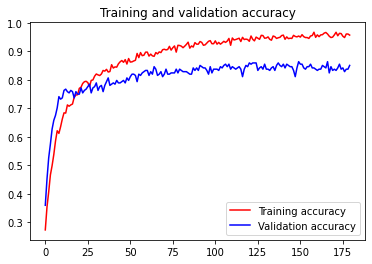

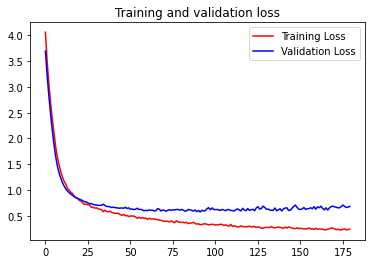

In [ ]:
def model_performance(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()

  plt.plot(epochs, loss, 'r', label='Training Loss')
  plt.plot(epochs, val_loss, 'b', label='Validation Loss')
  plt.title('Training and validation loss')
  
  plt.legend()
  plt.show()
  pass

model_performance(history)

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test)
print("Test Loss: ", loss)
print("Test Accuracy: ", accuracy)


8/8 [==============================] - 0s 2ms/step - loss: 0.5800 - accuracy: 0.8785
Test Loss:  0.5799553394317627
Test Accuracy:  0.8785424828529358


                   precision    recall  f1-score   support

baritone_dramatic       0.92      0.89      0.90        64
    bass_dramatic       0.90      0.94      0.92        49
   tenor_dramatic       0.86      0.87      0.87        63
      tenor_lyric       0.84      0.83      0.84        71

         accuracy                           0.88       247
        macro avg       0.88      0.88      0.88       247
     weighted avg       0.88      0.88      0.88       247



['/content/gdrive/My Drive/UpworkNotebooks/Opera Files/Models/Development/Males_A/Reports/Males_A_performance_report.joblib']

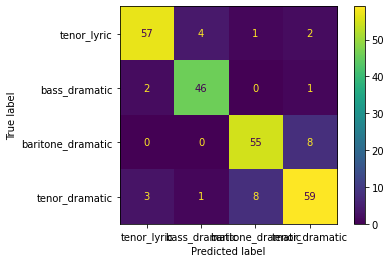

In [ ]:
y_pred = model.predict(x_test)
y_pred_list = [y_pred[i].argmax() for i in range(len(x_test))]
y_true_list = [y_test[i].argmax() for i in range(len(x_test))]

label_mapping = load(main_dir +  'Models/Development/Males_A/Reports/Males_A_label_mapping.joblib')

y_pred_list = [label_mapping[item] for item in y_pred_list]
y_true_list = [label_mapping[item] for item in y_true_list]

true_labels = targets_to_labels(y_true_list)
pred_labels = targets_to_labels(y_pred_list)


conf_matrix = metrics.confusion_matrix(true_labels, pred_labels)
cm = metrics.ConfusionMatrixDisplay(conf_matrix, display_labels=to_evaluate).plot()
precision, recall, f_score, _ = metrics.precision_recall_fscore_support(y_true_list, y_pred_list, average='macro')
con_mat_norm = np.around(conf_matrix.astype('int') / conf_matrix.sum(axis=1)[:, np.newaxis], decimals=2)

performance_report = {}
performance_report['precision'] = precision
performance_report['recall'] = recall
performance_report['f_score'] = f_score
performance_report['conf_matrix'] = conf_matrix
performance_report['classification_report'] = metrics.classification_report(true_labels,pred_labels)
performance_report['avg_roc_auc_score'] = metrics.roc_auc_score(y_test,y_pred, multi_class='ovr')
performance_report['spcfc_roc_auc_score'] = metrics.roc_auc_score(y_test,y_pred, average=None ,multi_class='ovr')

print(performance_report['classification_report'])
dump(performance_report, main_dir +  'Models/Development/Males_A/Reports/Males_A_performance_report.joblib')


In [ ]:
model.save(main_dir + 'Models/Development/Males_A/ANN/Males_A')
print('Development Model saved')

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/UpworkNotebooks/Opera Files/Models/Development/Males_A/ANN/Males_A/assets
Development Model saved


# Save To Production


In [ ]:
# Saving the acceptable model
dump(pca, main_dir + 'Models/Production/Males_A/PCA/Males_A_pca.joblib') 
print('pca model saved')
dump(standard_scaler, main_dir + 'Models/Production/Males_A/Scaler/Males_A_scaler.joblib')
print('Scaler model saved')
model.save(main_dir + 'Models/Production/Males_A/ANN/Males_A')
print('ANN model saved')
dump(label_mapping, main_dir +  'Models/Production/Males_A/Reports/Males_A_label_mapping.joblib')
print('Label mapping saved')
dump(performance_report, main_dir +  'Models/Production/Males_A/Reports/Males_A_performance_report.joblib')
print('Performance report saved')

datasets = [x_train, y_train, x_test, y_test, x_dev, y_dev]
dataset_names = ['x_train', 'y_train', 'x_test', 'y_test', 'x_dev', 'y_dev']
for dataset, dataset_name in zip(datasets, dataset_names):
  df = pd.DataFrame(dataset)
  folder = dataset_name.split('_')[1].capitalize()
  df.to_csv(main_dir + 'Models/Production/Males_A/Data/{0}/Males_A_{1}.csv'.format(folder, dataset_name), index=False)

print('Datasets used saved')

pca model saved
Scaler model saved
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/UpworkNotebooks/Opera Files/Models/Production/Males_A/ANN/Males_A/assets
ANN model saved
Label mapping saved
Performance report saved
Datasets used saved


In [6]:
pr = load(main_dir +  'Models/Production/Males_A/Reports/Males_A_performance_report.joblib')
print(pr['spcfc_roc_auc_score'])
print(pr['avg_roc_auc_score'])

[0.97575137 0.97701505 0.97584541 0.95526569]
0.9709693775527659
